## Importação dos pacotes

In [1]:
# importar pacotes necessários
import numpy as np
import pandas as pd

In [2]:
# definir parâmetros extras
#pd.set_option('precision', 2)
pd.set_option('display.max_columns', 100)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# importar pacotes usados na seleção do modelo e na medição da precisão
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

# importar os pacotes necessários para os algoritmos de classificação
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Carga dos dados de entrada

In [5]:
# carregar arquivo de dados de treino
data = pd.read_csv('zoo-train.csv', index_col='animal_name')

# mostrar tamanho
print(data.shape)

# mostrar alguns exemplos de registros
data.head()

(101, 17)


hair feathers eggs milk airborne aquatic predator toothed  \
animal_name                                                             
swan           n        y    y    n        y       y        n       n   
tuatara        n        n    y    n        n       n        y       y   
bass           n        n    y    n        n       y        y       y   
hare           y        n    n    y        n       n        n       y   
chub           n        n    y    n        n       y        y       y   

            backbone breathes venomous fins  legs tail domestic catsize  \
animal_name                                                               
swan               y        y        n    n     2    y        n       y   
tuatara            y        y        n    n     4    y        n       n   
bass               y        n        n    y     0    y        n       n   
hare               y        y        n    n     4    y        n       n   
chub               y        n        n    y     0    y        n       n   

             class_type  
animal_name              
swan                  2  
tuatara               3  
bass                  4  
hare                  1  
chub                  4

In [6]:
# carregar arquivo de dados de treino
data2 = pd.read_csv('zoo-train2.csv', index_col='animal_name')

# mostrar tamanho
print(data2.shape)

# mostrar alguns exemplos de registros
data2.head()

(43, 17)


hair feathers eggs milk airborne aquatic predator toothed  \
animal_name                                                             
boa            n        n    y    n        n       n        y       y   
barracuda      n        n    y    n        n       y        y       y   
mosquito       n        n    y    n        y       n        n       n   
anchovy        n        n    y    n        n       y        n       n   
spider         n        n    y    n        n       n        y       y   

            backbone breathes venomous fins  legs tail domestic catsize  \
animal_name                                                               
boa                y        y        n    n     0    y        n       y   
barracuda          y        n        n    y     0    y        n       y   
mosquito           n        y        n    n     6    n        n       n   
anchovy            y        n        n    y     0    y        n       n   
spider             n        y        y    n     8    n        n       n   

             class_type  
animal_name              
boa                   3  
barracuda             4  
mosquito              6  
anchovy               4  
spider                7

In [7]:
# unir ambos os dados de treinamento
data = data.append(data2)

# mostrar tamanho
print(data.shape)

# mostrar alguns exemplos de registros
data.tail()

(144, 17)


hair feathers eggs milk airborne aquatic predator toothed  \
animal_name                                                             
gecko          n        n    y    n        n       n        n       y   
gharial        n        n    y    n        n       y        y       y   
trout          n        n    y    n        n       y        n       n   
skink          n        n    y    n        n       n        n       y   
palmetto       n        n    y    n        y       n        y       n   

            backbone breathes venomous fins  legs tail domestic catsize  \
animal_name                                                               
gecko              y        y        n    n     4    y        y       n   
gharial            y        y        n    n     4    y        n       y   
trout              y        n        n    y     0    y        n       y   
skink              y        y        n    n     4    y        n       n   
palmetto           n        y        n    n     6    n        n       n   

             class_type  
animal_name              
gecko                 3  
gharial               3  
trout                 4  
skink                 3  
palmetto              6

In [8]:
# transformar y/n em 0/1

bool_cols = data.columns.values.tolist()
bool_cols.remove('legs')
bool_cols.remove('class_type')

for col in bool_cols:
    data[col] = data[col].map({'n': 0, 'y': 1}).astype(int)

In [9]:
# definir dados de entrada

X = data.drop(['class_type'], axis=1) # tudo, exceto a coluna alvo
y = data['class_type'] # apenas a coluna alvo

print('Forma dos dados originais:', X.shape, y.shape)

Forma dos dados originais: (144, 16) (144,)


## Separação dos dados de treino e teste

## Treinamento dos modelos preditivos

In [13]:
def evaluate_model_cv(model, X=X, y=y):
  kfold = KFold(n_splits=10, random_state=42)
  results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', verbose=1)
  score = results.mean() * 100
  stddev = results.std() * 100
  print(model, '\nCross-Validation Score: %.2f (%.2f) %%' % (score, stddev))
  return score

In [14]:
# faz o ajuste fino do modelo, calculando os melhores hiperparâmetros
def fine_tune_model(model, params, X=X, y=y):
  print('\nFine Tuning Model:')
  print(model, "\nparams:", params)

  kfold = KFold(n_splits=10, random_state=42)
  grid = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=kfold, verbose=1)
  grid.fit(X, y)

  print('\nGrid Score: %.2f %%' % (grid.best_score_ * 100))
  print('Best Params:', grid.best_params_)
 
  return grid

## Avaliação e ajuste fino de cada modelo preditivo

In [15]:
# A) Logistic Regression
model = LogisticRegression(random_state=42, solver='lbfgs', multi_class='auto', max_iter=500, C=100)
evaluate_model_cv(model)

params = {'solver':['liblinear', 'lbfgs'], 'C':np.logspace(-3,3,7)}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False) 
Cross-Validation Score: 96.48 (4.76) %


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.1s finished


In [16]:
# B) Decision Tree
model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=11)
evaluate_model_cv(model)

params = {'criterion':['gini','entropy'], 'max_depth':[3,5,7,11]}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best') 
Cross-Validation Score: 97.29 (4.47) %


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [17]:
# C) K-Nearest Neighbours
model = KNeighborsClassifier(n_neighbors=1)
evaluate_model_cv(model)

params = {'n_neighbors':[1, 3, 5, 7, 9]}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform') 
Cross-Validation Score: 97.19 (4.70) %


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [18]:
# D) Support Vector Machine (SVM)
model = SVC(random_state=42, C=10, gamma=0.1, kernel='rbf')
evaluate_model_cv(model)

params = {'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100], 'kernel':['linear', 'rbf']}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False) 
Cross-Validation Score: 98.57 (2.86) %


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


In [19]:
# E) Random Forest
model = RandomForestClassifier(random_state=42, max_features='auto', n_estimators=10)
evaluate_model_cv(model)

params = {'n_estimators':[10, 50, 100, 500], 'max_features':['auto', 'sqrt', 'log2']}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False) 
Cross-Validation Score: 96.52 (4.72) %


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


In [20]:
# F) Stochastic Gradient Descent (SGD)
model = SGDClassifier(random_state=42, max_iter=100, tol=0.1)
evaluate_model_cv(model)

params = {'max_iter':[100, 200, 350, 500, 1000], 'tol':[0.1, 0.01]}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.1,
       validation_fraction=0.1, verbose=0, warm_start=False) 
Cross-Validation Score: 92.33 (6.66) %


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


In [21]:
# G) Perceptron
model = Perceptron(random_state=42, max_iter=100, tol=0.01)
evaluate_model_cv(model)

params = {'max_iter':[100, 200, 350, 500, 1000], 'tol':[0.1, 0.01, 0.001]}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=100, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=42, shuffle=True, tol=0.01,
      validation_fraction=0.1, verbose=0, warm_start=False) 
Cross-Validation Score: 93.67 (6.73) %


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


In [22]:
# H) Naïve Bayes
model = GaussianNB(priors=None, var_smoothing=1e-08)
evaluate_model_cv(model)

params = {'priors': [None], 'var_smoothing': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianNB(priors=None, var_smoothing=1e-08) 
Cross-Validation Score: 97.19 (4.70) %


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


In [23]:
# I) Linear SVM
model = LinearSVC(random_state=42, max_iter=1000, C=10)
evaluate_model_cv(model)

params = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear faile

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0) 
Cross-Validation Score: 95.76 (5.69) %


/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


In [24]:
# J) Ada Boost
model = AdaBoostClassifier(DecisionTreeClassifier(random_state=42), n_estimators=5)
evaluate_model_cv(model)

params = {'n_estimators':[1,3,5,7,11]}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          learning_rate=1.0, n_estimators=5, random_state=None) 
Cross-Validation Score: 95.19 (4.34) %


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


In [25]:
# K) Gradient Boosting
model = GradientBoostingClassifier(random_state=42, max_depth=3)
evaluate_model_cv(model)

'''
params = {
    "learning_rate":[0.01, 0.05, 0.1],
    "max_depth":[3, 5, 7],
    "max_features":["log2", "sqrt"],
    "criterion":["friedman_mse", "mae"],
    "subsample":[0.5, 0.75, 1.0],
}
'''

params = {'max_depth':[3, 5, 7]}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False) 
Cross-Validation Score: 97.24 (4.51) %


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.5s finished


In [26]:
# M) Multi-Layer Perceptron (MLP)
model = MLPClassifier(random_state=42, solver='lbfgs', alpha=0.1, hidden_layer_sizes=(15,))
evaluate_model_cv(model)

params = {'alpha':[1,0.1,0.01,0.001,0.0001,0]}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) 
Cross-Validation Score: 97.86 (4.57) %


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.3s finished


In [27]:
# N) Linear Discriminant Analysis (LDA)
model = LinearDiscriminantAnalysis(solver='svd')
evaluate_model_cv(model)

params = {'solver':['svd', 'lsqr']} #, 'eigen']}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables 

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001) 
Cross-Validation Score: 92.33 (5.96) %


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


## Comparação final entre os algoritmos

In [28]:
models = []
models.append(('LR', LogisticRegression(random_state=42, solver='lbfgs', multi_class='auto', max_iter=500, C=100)))
models.append(('DT', DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=11)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=1)))
models.append(('SVM', SVC(random_state=42, C=10, gamma=0.1, kernel='rbf')))
models.append(('RF', RandomForestClassifier(random_state=42, max_features='auto', n_estimators=10)))
models.append(('SGD', SGDClassifier(random_state=42, max_iter=100, tol=0.1)))
models.append(('NN', Perceptron(random_state=42, max_iter=100, tol=0.01)))
models.append(('NB', GaussianNB(priors=None, var_smoothing=1e-08)))
models.append(('LSVM', LinearSVC(random_state=42, max_iter=1000, C=10)))
models.append(('ABDT', AdaBoostClassifier(DecisionTreeClassifier(random_state=42), n_estimators=5)))
models.append(('GB', GradientBoostingClassifier(random_state=42, max_depth=3)))
models.append(('MLP', MLPClassifier(random_state=42, solver='lbfgs', alpha=0.1, hidden_layer_sizes=(15,))))
models.append(('LDA', LinearDiscriminantAnalysis(solver='svd')))

In [29]:
results = []
names = []
scores = []
stddevs = []

for name, model in models:
  kfold = KFold(n_splits=10, random_state=42)
  cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  scores.append(cv_results.mean() * 100)
  stddevs.append(cv_results.std() * 100)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.964762 (0.047581)
DT: 0.972857 (0.044673)
KNN: 0.971905 (0.046969)
SVM: 0.985714 (0.028571)
RF: 0.965238 (0.047239)
SGD: 0.923333 (0.066648)
NN: 0.936667 (0.067312)
NB: 0.971905 (0.046969)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

LSVM: 0.957619 (0.056922)
ABDT: 0.965714 (0.045466)
GB: 0.972381 (0.045115)
MLP: 0.978571 (0.045737)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.923333 (0.059608)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


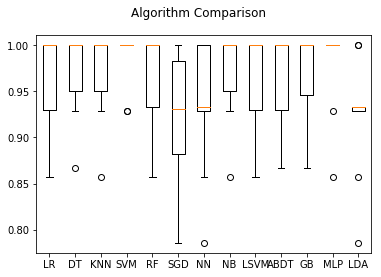

In [30]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [31]:
results = pd.DataFrame({'Model': names, 'Score': scores, 'Std Dev': stddevs})
results.sort_values(by='Score', ascending=False)

Model      Score   Std Dev
3    SVM  98.571429  2.857143
11   MLP  97.857143  4.573660
1     DT  97.285714  4.467316
10    GB  97.238095  4.511512
2    KNN  97.190476  4.696938
7     NB  97.190476  4.696938
9   ABDT  96.571429  4.546559
4     RF  96.523810  4.723896
0     LR  96.476190  4.758094
8   LSVM  95.761905  5.692219
6     NN  93.666667  6.731151
5    SGD  92.333333  6.664796
12   LDA  92.333333  5.960756